In [8]:
from doppler_imaging import *
import numpy as np
import paths

##############################################################################
####################    Configs     ##########################################
##############################################################################

from config_run import *

savedir = "igrinsK"
band = "K"
goodchips_run[instru][target][band] = [0, 1, 2, 3, 4, 5, 15, 16, 17, 18, 19]
nk = 105
nlat, nlon = 20, 40
use_eqarea = True

#################### Automatic ####################################

if True:
    # Auto consistent options
    contrast = "real"
    noisetype = "real"
    cut = nk - 70

    nobs = nobss[target]

    # set chips to include
    goodchips = goodchips_run[instru][target][band]
    nchip = len(goodchips)

    # set model files to use
    if "t1" in modelspec:
        model_datafile = paths.data / f'{instru}_{target}_{band}_{modelspec}.pickle'
        pmod = f'linbroad_{modelspec}'
        rv = rvs[target]

    line_file = paths.data / f'linelists/{pmod}_edited.clineslsd'
    cont_file = paths.data / f'linelists/{pmod}C.fits'

    # set solver parameters
    period = periods[target]
    inc = incs[target]
    vsini = vsinis[target]
    veq = vsini / np.sin(inc * np.pi / 180)

    # set time and period parameters
    timestamp = timestamps[target]
    phases = timestamp * 2 * np.pi / period # 0 ~ 2*pi in rad
    theta = 360.0 * timestamp / period      # 0 ~ 360 in degree

    kwargs_sim = dict(
        ydeg=ydeg_sim,
        udeg=udeg,
        nc=nc,
        veq=veq,
        inc=inc,
        nt=nobs,
        vsini_max=vsini_max,
        u1=u1,
        theta=theta)

    kwargs_run = kwargs_sim.copy()
    kwargs_run['ydeg'] = ydeg

    kwargs_IC14 = dict(
        phases=phases, 
        inc=inc, 
        vsini=vsini, 
        LLD=LLD, 
        eqarea=use_eqarea, 
        nlat=nlat, 
        nlon=nlon,
        alpha=alpha,
        ftol=ftol
    )

    kwargs_fig = dict(
        goodchips=goodchips,
        noisetype=noisetype,
        contrast=contrast,
        savedir=savedir
    )


Using real observation /Users/xqchen/workspace/igrins_doppler_imaging/src/data/IGRINS_W1049B_K_t1500g1000f8.pickle
nobs: 14, nchip: 11, npix: 1848
mean_spectrum: (11, 1848)
template: (14, 11, 1848)
observed: (14, 11, 1648)
wav: (11, 1648), wav0: (11, 1848)
IGRINS
dbeta 6.718406274438128e-06
chip 0
chip 1
chip 2
chip 3
chip 4
chip 5
chip 15
chip 16
chip 17
chip 18
chip 19
chip: 0 obs: 0 offset: 0
chip: 0 obs: 1 offset: 0
chip: 0 obs: 2 offset: -1
chip: 0 obs: 3 offset: 0
chip: 0 obs: 4 offset: 0
chip: 0 obs: 5 offset: 0
chip: 0 obs: 6 offset: 0
chip: 0 obs: 7 offset: 0
chip: 0 obs: 8 offset: 0
chip: 0 obs: 9 offset: 0
chip: 0 obs: 10 offset: 0
chip: 0 obs: 11 offset: -1
chip: 0 obs: 12 offset: 0
chip: 0 obs: 13 offset: 0
chip: 1 obs: 0 offset: 0
chip: 1 obs: 1 offset: 0
chip: 1 obs: 2 offset: 0
chip: 1 obs: 3 offset: 0
chip: 1 obs: 4 offset: 0
chip: 1 obs: 5 offset: 0
chip: 1 obs: 6 offset: 0
chip: 1 obs: 7 offset: 0
chip: 1 obs: 8 offset: 0
chip: 1 obs: 9 offset: 0
chip: 1 obs: 10 offs

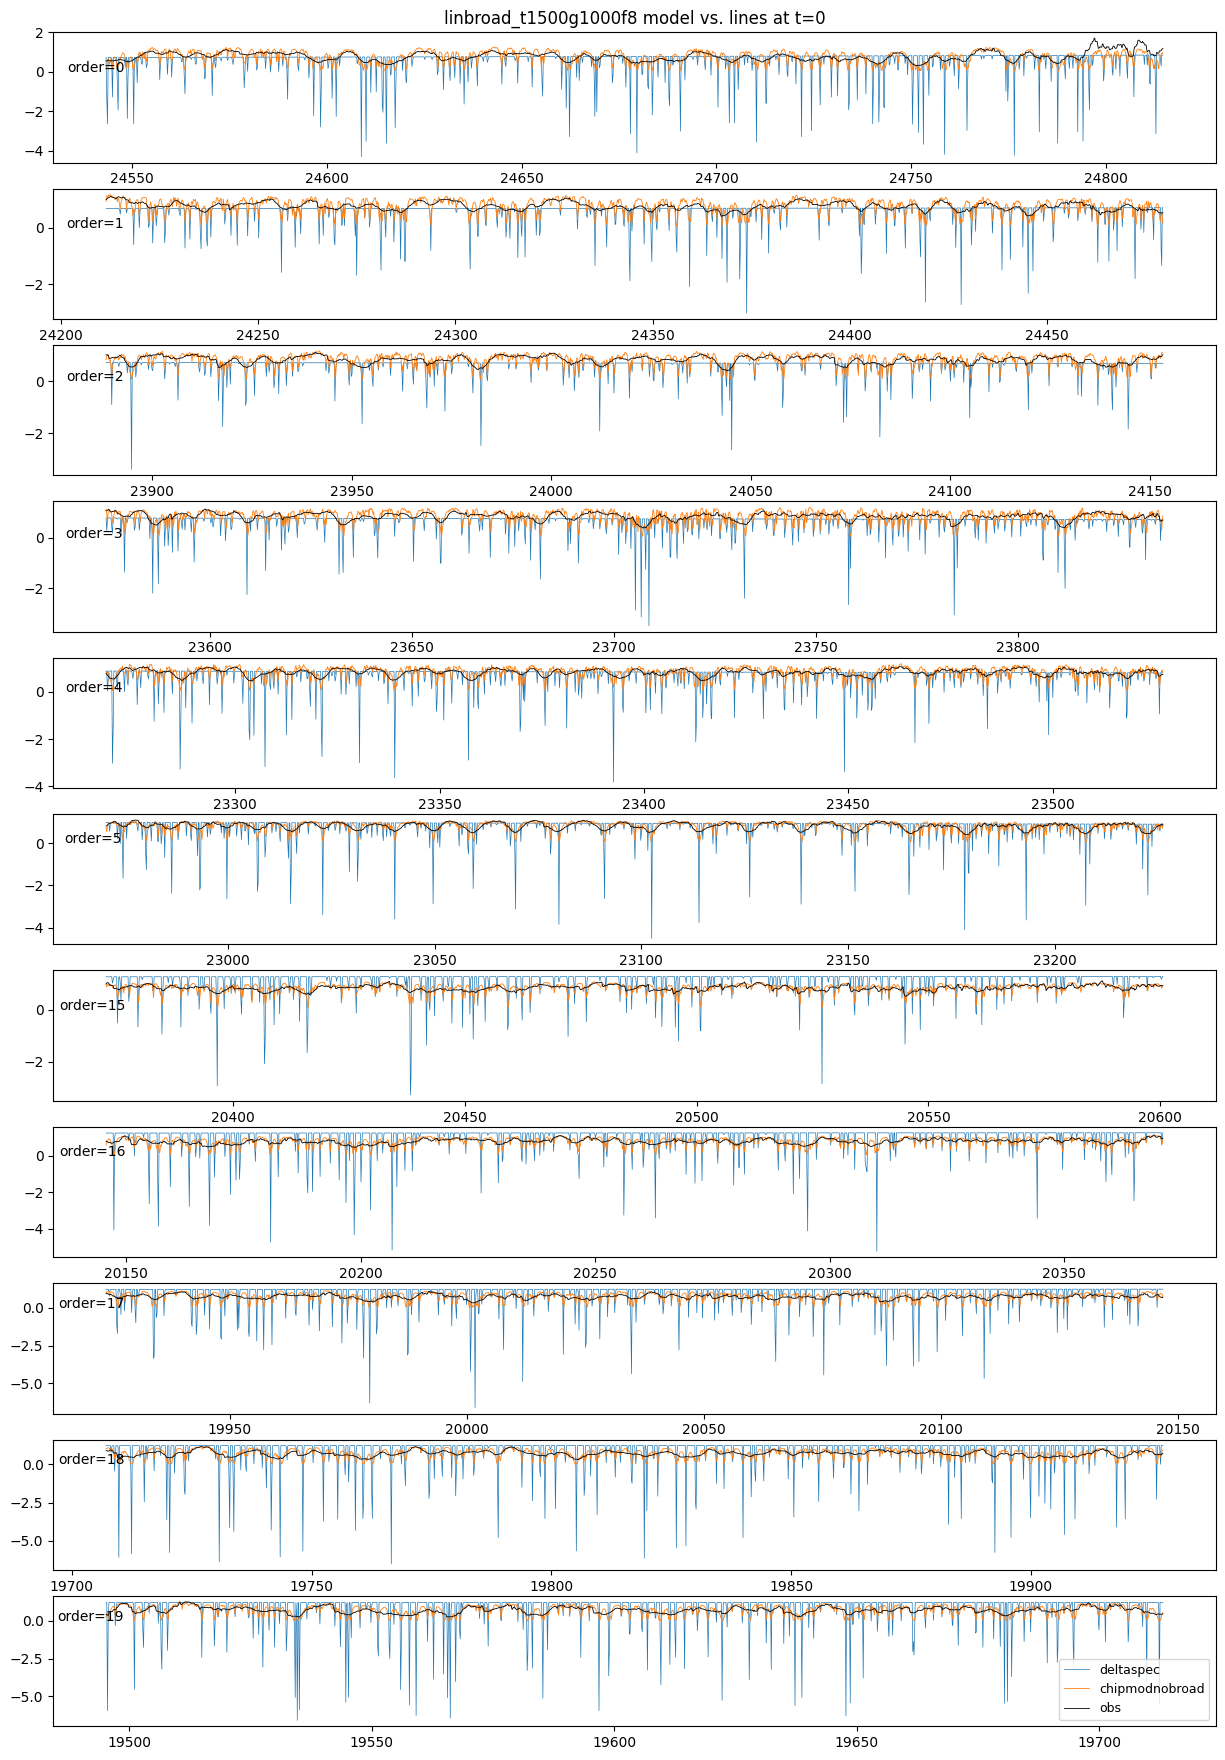

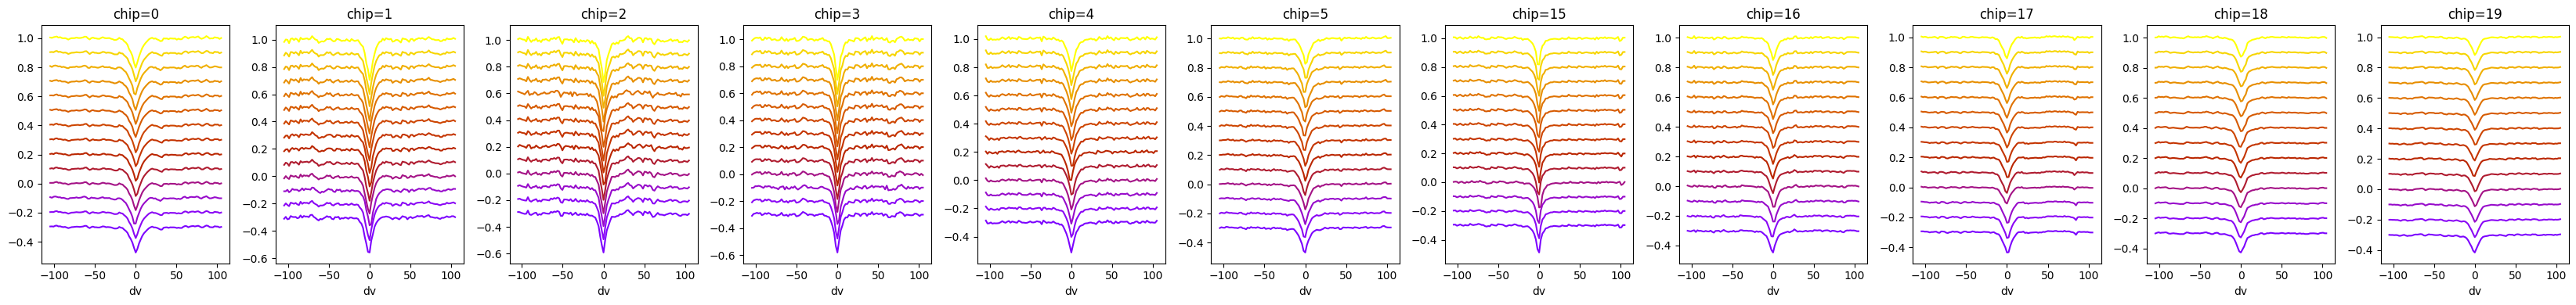

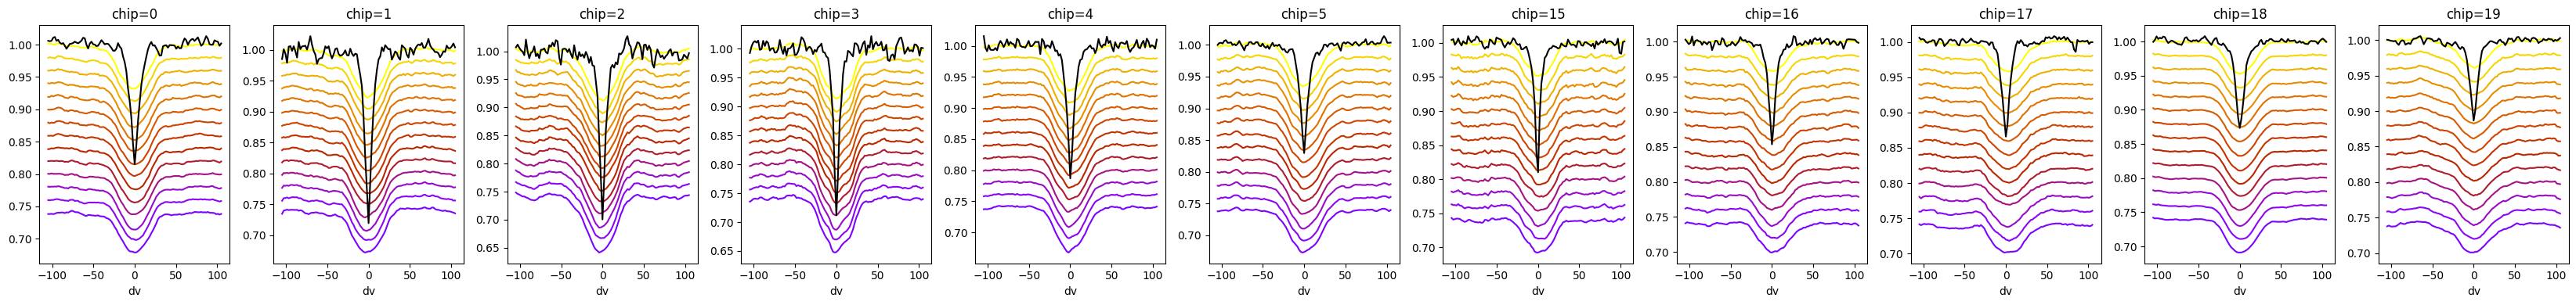

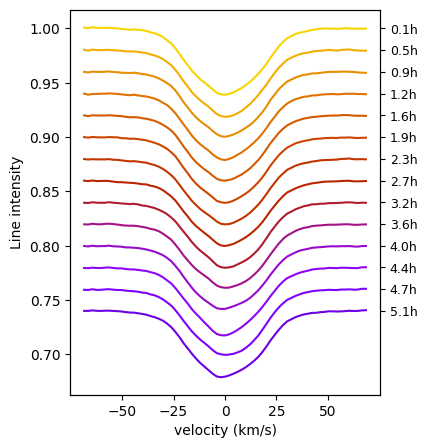

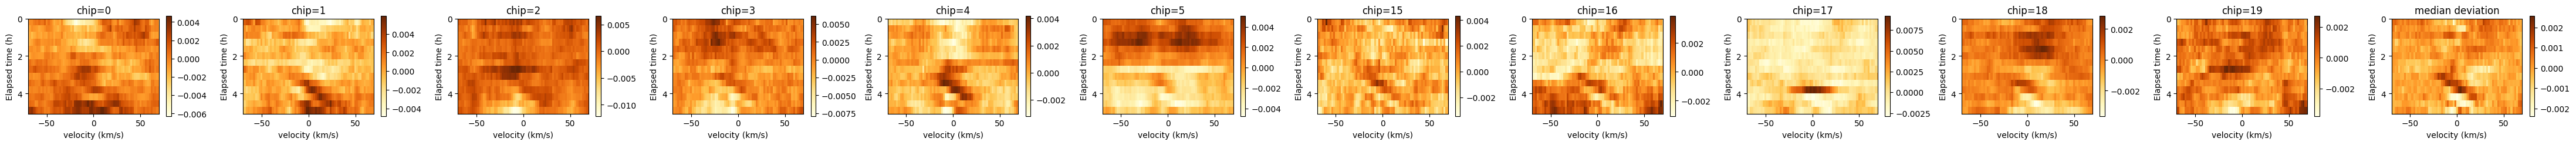

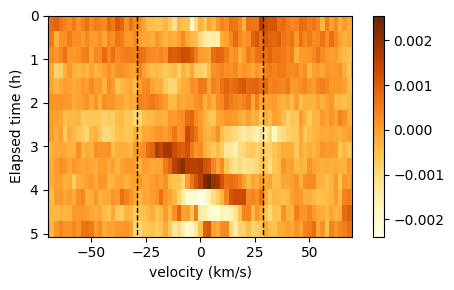

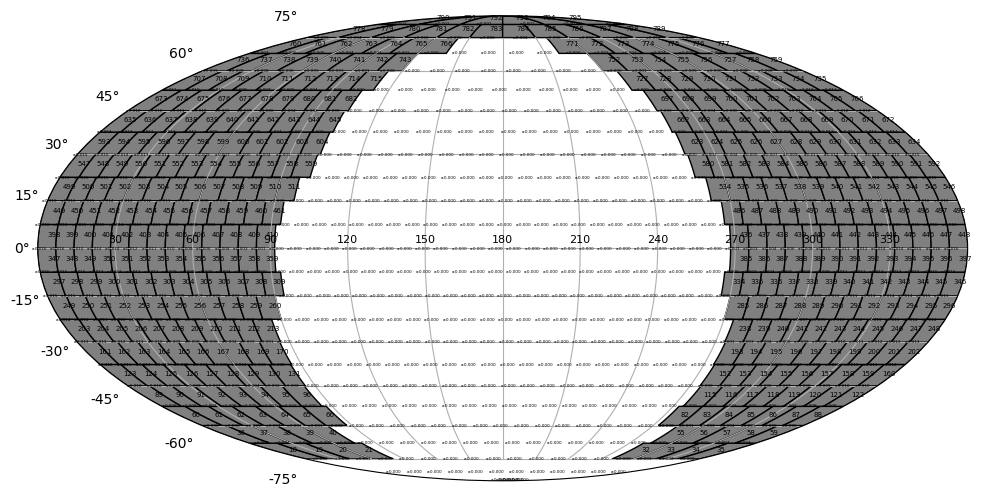

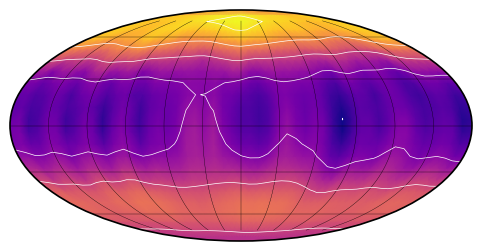

In [9]:
assert simulation_on == False
assert savedir == "igrinsK"
print(f"Using real observation {model_datafile}")

# Load data from pickle fit
mean_spectrum, template, observed, residual, error, wav_nm, wav0_nm = load_data(model_datafile, instru, nobs, goodchips)

# Compute LSD mean profile
intrinsic_profiles, obskerns_norm = make_LSD_profile(instru, template, observed, wav_nm, goodchips, pmod, line_file, cont_file, nk, vsini, rv, 
                                                     period, timestamps[target], savedir, cut=cut)

# Solve by 5 solvers
for alpha in [5000]:
    kwargs_IC14 = dict(
        phases=phases, 
        inc=inc, 
        vsini=vsini, 
        LLD=LLD, 
        eqarea=use_eqarea, 
        nlat=nlat, 
        nlon=nlon,
        alpha=alpha,
        ftol=ftol
    )
    
    bestparamgrid_r, res = solve_IC14new(intrinsic_profiles, obskerns_norm, kwargs_IC14, kwargs_fig, 
                                         annotate=False, colorbar=False, spotfit=False,
                                         create_obs_from_diff=False)

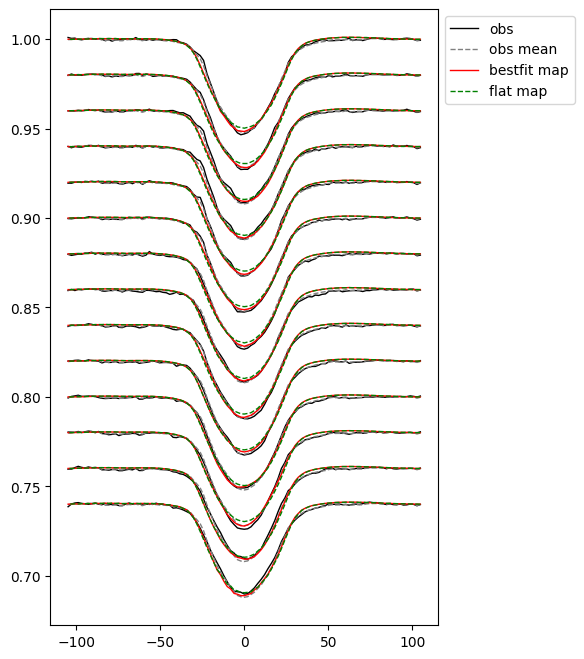

In [10]:
obs_2d = np.reshape(res['sc_observation_1d'], (nobs, nk))
bestmodel_2d = np.reshape(res['model_observation'], (nobs, nk))
flatmodel_2d = np.reshape(res['flatmodel'], (nobs, nk))

plt.figure(figsize=(5, 8))
gap=0.02
for i in range(nobs):
    plt.plot(res['dv'], obs_2d[i] - gap*i, color='k', linewidth=1)
    #plt.plot(obs[i] - 0.02*i, '.', color='k', markersize=2)
    plt.plot(res['dv'], obs_2d.mean(0) - gap*i, '--', color='gray', linewidth=1)
    plt.plot(res['dv'], bestmodel_2d[i] - gap*i, color='red', linewidth=1)
    plt.plot(res['dv'], flatmodel_2d[i] - gap*i, '--', color='g', linewidth=1)
plt.legend(labels=['obs', 'obs mean', 'bestfit map', 'flat map'], bbox_to_anchor=(1,1))

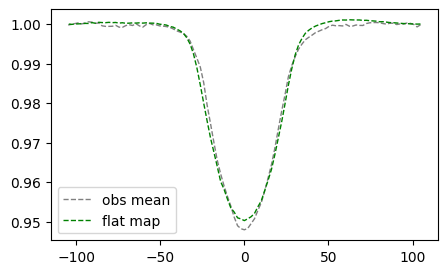

In [11]:
plt.figure(figsize=(5, 3))
plt.plot(res['dv'], obs_2d.mean(0), '--', color='gray', linewidth=1)
plt.plot(res['dv'], flatmodel_2d[0], '--', color='g', linewidth=1)
#plt.plot(res['dv'], bestmodel_2d[0], color='r', linewidth=1)

plt.legend(labels=['obs mean', 'flat map'])
plt.show()

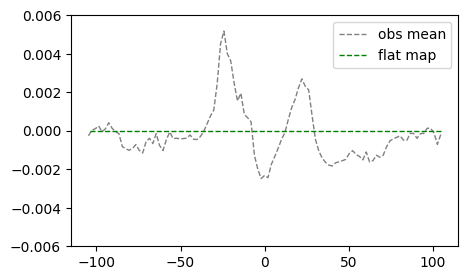

In [14]:
plt.figure(figsize=(5, 3))
plt.plot(res['dv'], obs_2d.mean(0) - flatmodel_2d[0], '--', color='gray', linewidth=1)
plt.plot(res['dv'], flatmodel_2d[0] - flatmodel_2d[0], '--', color='g', linewidth=1)
#plt.plot(res['dv'], bestmodel_2d[0], color='r', linewidth=1)
plt.ylim(-0.006, 0.006)
plt.legend(labels=['obs mean', 'flat map'])
plt.show()

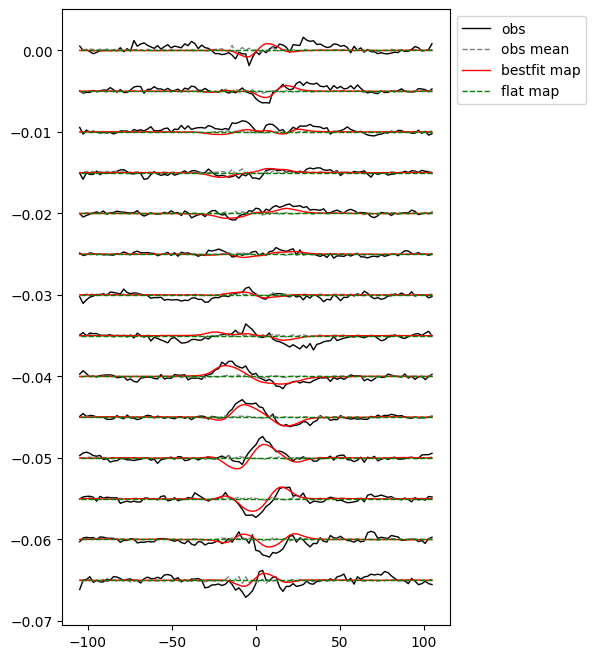

In [5]:
obs_2d = np.reshape(res['sc_observation_1d'], (nobs, nk))
bestmodel_2d = np.reshape(res['model_observation'], (nobs, nk))
flatmodel_2d = np.reshape(res['flatmodel'], (nobs, nk))

plt.figure(figsize=(5, 8))
gap=0.005
for i in range(nobs):
    plt.plot(res['dv'], obs_2d[i] - flatmodel_2d[i] - gap*i, color='k', linewidth=1)
    #plt.plot(obs[i] - 0.02*i, '.', color='k', markersize=2)
    plt.plot(res['dv'], obs_2d.mean(0) - flatmodel_2d[i] - gap*i, '--', color='gray', linewidth=1)
    plt.plot(res['dv'], bestmodel_2d[i] - flatmodel_2d[i] - gap*i, color='red', linewidth=1)
    plt.plot(res['dv'], flatmodel_2d[i] - flatmodel_2d[i] - gap*i, '--', color='g', linewidth=1)
plt.legend(labels=['obs', 'obs mean', 'bestfit map', 'flat map'], bbox_to_anchor=(1,1))

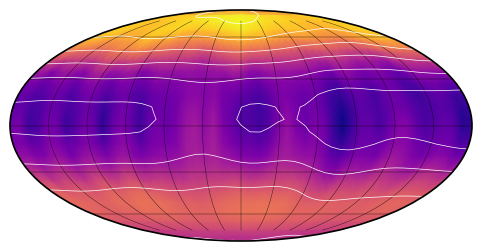

In [3]:
plot_IC14_map(bestparamgrid_r, clevel=7, sigma=2.5)

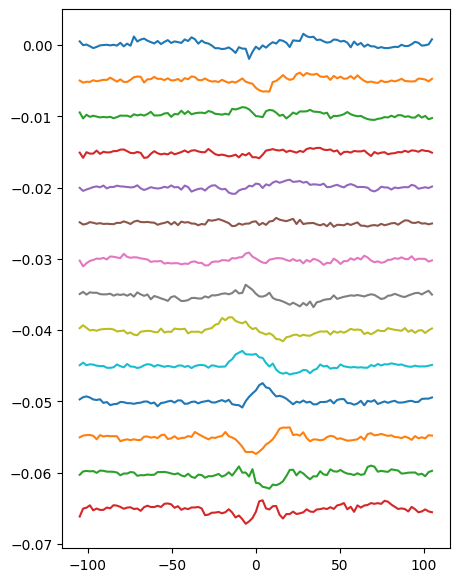

In [10]:
uniform_profiles = np.zeros((nchip, nk))
for i, jj in enumerate(goodchips):
    uniform_profiles[i] = obskerns_norm[:,i].mean(axis=0) 
    # is each chip's mean kern over epoches
mean_dev = np.median(np.array([obskerns_norm[:,i]-uniform_profiles[i] for i in range(nchip)]), axis=0) # mean over chips
plt.figure(figsize=(5,7))
for t in range(14):
    plt.plot(res['dv'], mean_dev[t]  - 0.005*t)

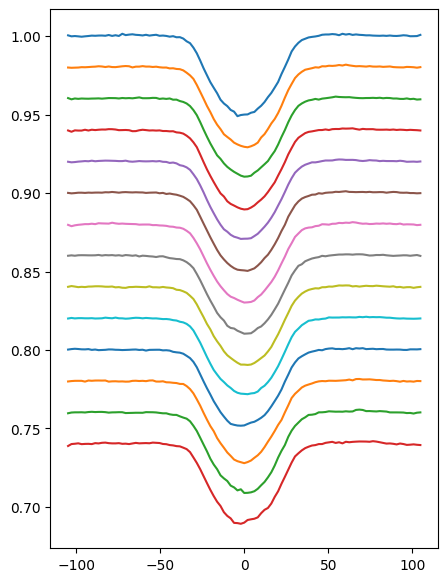

In [14]:
plt.figure(figsize=(5,7))
for t in range(14):
    plt.plot(res['dv'], mean_dev[t] + flatmodel_2d[t]  - 0.02*t)

In [16]:
new_observation_2d = mean_dev + flatmodel_2d
new_observation_1d = new_observation_2d.ravel()

In [17]:
w_observation = res['w_observation']

# Scale the observations to match the model's equivalent width:
out, eout = an.lsq((new_observation_1d, np.ones(nobs*nk)), res['flatmodel'], w=w_observation)
sc_observation_1d = new_observation_1d * out[0] + out[1]

In [18]:
### Solve!
Rmatrix = res['Rmatrix']
ncell = res['bestparams'].shape[0]
flatguess = 100*np.ones(ncell)
bounds = [(1e-6, 300)]*ncell

fitargs = (sc_observation_1d, w_observation, Rmatrix, alpha)
bfit = an.gfit(dime.entropy_map_norm_sp, flatguess, fprime=dime.getgrad_norm_sp, args=fitargs, ftol=ftol, disp=1, maxiter=1e4, bounds=bounds)
bestparams = bfit[0]
model_observation = dime.normalize_model(np.dot(bestparams, Rmatrix), nk)
metric, chisq, entropy = dime.entropy_map_norm_sp(bestparams, *fitargs, retvals=True)
print("metric:", metric, "chisq:", chisq, "entropy:", entropy)

  ITER       METRIC         FACTOR             DMETRIC
      1   -33335.308833   1.50000e+00   -4.667e-01
      2   -33335.992653   2.25000e+00   -6.838e-01
      3   -33336.982967   3.37500e+00   -9.903e-01
      4   -33338.392058   5.06250e+00   -1.409e+00
      5   -33340.344432   7.59375e+00   -1.952e+00
      6   -33342.943318   1.13906e+01   -2.599e+00
      7   -33346.199766   1.70859e+01   -3.256e+00
      8   -33349.924055   2.56289e+01   -3.724e+00
      9   -33353.637614   3.84434e+01   -3.714e+00
     10   -33356.667351   5.76650e+01   -3.030e+00
     11   -33358.564920   8.64976e+01   -1.898e+00
     12   -33359.516289   1.29746e+02   -9.514e-01
     13   -33360.027847   1.94620e+02   -5.116e-01
     14   -33360.394700   2.91929e+02   -3.669e-01
     15   -33360.689446   4.37894e+02   -2.947e-01
     16   -33360.804966   6.56841e+02   -1.155e-01
     17   -33360.804966   3.28420e+02   -1.155e-01
     18   -33360.804966   1.64210e+02   -1.155e-01
     19   -33360.804966   8

In [20]:
# reshape into list
this_map = res['mmap']
start=0
bestparamlist = []
for m in range(this_map.nlat):
    bestparamlist.append(bestparams[start:start+this_map.nlon[m]])
    start = start + this_map.nlon[m]
# interp into rectangular array
max_length = max([len(x) for x in bestparamlist])
stretched_arrays = []
for array in bestparamlist:
    x_old = np.arange(len(array))
    x_new = np.linspace(0, len(array) - 1, max_length)
    y_new = np.interp(x_new, x_old, array)
    stretched_arrays.append(y_new)

bestparamgrid = np.vstack(stretched_arrays)
bestparamgrid_r = np.roll(
        np.flip(bestparamgrid, axis=1), int(0.5*bestparamgrid.shape[1]), axis=1)

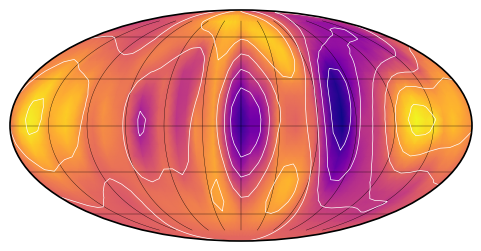

In [33]:
plot_IC14_map(bestparamgrid_r, clevel=6, sigma=1)